In [ ]:
from dolfinx import mesh, fem
from dolfinx.fem import petsc as fem_petsc
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import numpy as np
import matplotlib.pyplot as plt

# --- Parametri ---
c = 1.0          # velocità
L = 2.0          # lunghezza dominio
nx = 500         # numero intervalli
T = 1            # tempo finale
dt = 0.001       # passo temporale
nt = int(T / dt) + 1
t_vals = np.linspace(0., T, nt)
plot_times = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]


# --- Mesh e spazio ---
domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0.0, L])
V = fem.functionspace(domain, ("Lagrange", 1))

# --- Condizioni al contorno Dirichlet u=0 ---
u_bc = fem.Function(V)
u_bc.x.array[:] = 0.0
facets = mesh.locate_entities_boundary(
    domain, dim=0,
    marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], L)
)
dofs = fem.locate_dofs_topological(V, entity_dim=0, entities=facets)
bc = fem.dirichletbc(u_bc, dofs)

# --- Funzioni temporali ---
u0 = fem.Function(V)  # u^{n-1}
u1 = fem.Function(V)  # u^{n}
u_new = fem.Function(V)  # u^{n+1}

# --- Inizializzazione ---
x_coords = V.tabulate_dof_coordinates()[:, 0]
u1.x.array[:] = gaussian(x_coords)
u0.x.array[:] = u1.x.array  # velocità iniziale = 0

# --- Variabili per forma debole ---
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# --- Matrice A (costante) ---
a_form = (u * v / dt**2) * ufl.dx + c**2 * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
A = fem.petsc.assemble_matrix(fem.form(a_form), bcs=[bc])
A.assemble()

solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType("preonly")
solver.getPC().setType("lu")

# --- Loop temporale ---
for t_current in t_vals:

    # Grafico nei tempi richiesti
    if np.any(np.isclose(t_current, plot_times, atol=dt / 2)):
        plt.plot(x_coords, u1.x.array, label=f"t={t_current:.2f}")

    # Salta il passo temporale 0
    if np.isclose(t_current, T):
        break

    # --- Termine destro b ---
    L_form = (2.0 * u1 * v / dt**2 - u0 * v / dt**2) * ufl.dx
    b = fem.petsc.assemble_vector(fem.form(L_form))
    fem.petsc.apply_lifting(b, [fem.form(a_form)], bcs=[[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [bc])

    # --- Risoluzione per u_new ---
    solver.solve(b, u_new.x.petsc_vec)
    u_new.x.scatter_forward()

    # --- Aggiornamento per passo successivo ---
    u0.x.array[:] = u1.x.array
    u1.x.array[:] = u_new.x.array

# --- Plot finale ---
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.show()


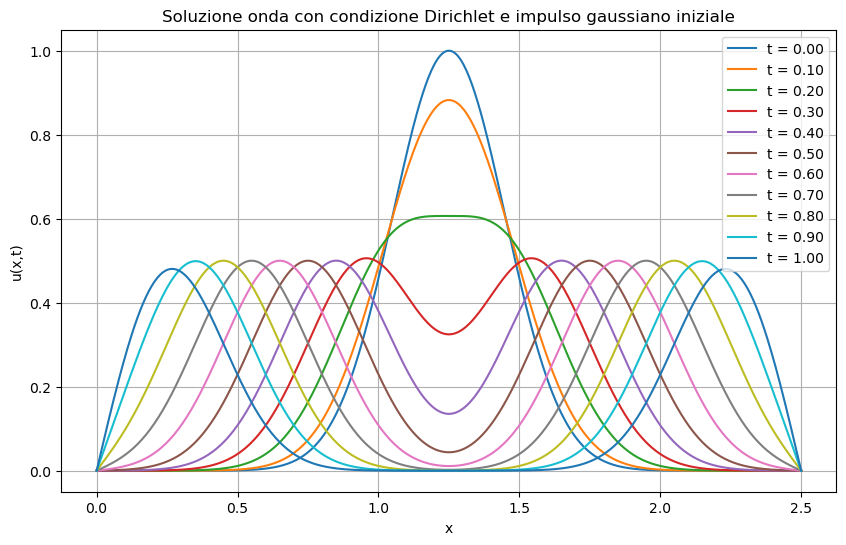

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri
L = 2.5
c = 1.0
N_modes = 50
nx = 500
x = np.linspace(0, L, nx)

# Funzione iniziale: impulso gaussiano centrato a L/2
sigma = 0.2
f = np.exp(-((x - L/2)**2) / (2*sigma**2))

# Calcolo coefficienti A_n
A = np.zeros(N_modes)
for n in range(1, N_modes+1):
    A[n-1] = 2/L * np.trapezoid(f * np.sin(n * np.pi * x / L), x)

# Funzione soluzione u(x,t)
def u_xt(x, t):
    u = np.zeros_like(x)
    for n in range(1, N_modes+1):
        omega_n = n * np.pi * c / L
        u += A[n-1] * np.cos(omega_n * t) * np.sin(n * np.pi * x / L)
    return u

# Tempi in cui calcolare la soluzione
times = np.linspace(0., 1., 11)

plt.figure(figsize = (10,6))
for t in times:
    plt.plot(x, u_xt(x, t), label=f't = {t:.2f}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Soluzione onda con condizione Dirichlet e impulso gaussiano iniziale')
plt.legend()
plt.grid(True)
plt.show()

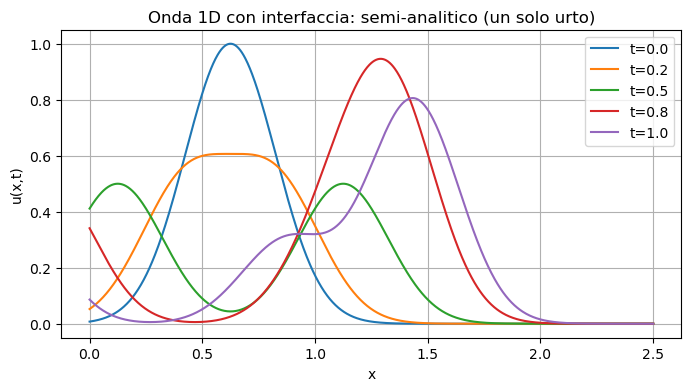

In [1]:
import numpy as np
import matplotlib.pyplot as plt

L   = 2.5
x   = np.linspace(0, L, 1000)
T   = 1.0
x0  = L/2          # interfaccia
c1, c2 = 1.0, 0.5

def gaussian(z, sigma):
    return np.exp(-0.5*(z/sigma)**2)

x_c   = L/4        # centro iniziale a sinistra dell’interfaccia
sigma = 0.2

# coefficienti di ampiezza per questa PDE: u_tt = d_x(c^2 u_x)
rA = (c1**2 - c2**2) / (c1**2 + c2**2)
tA = (2*c1**2)      / (c1**2 + c2**2)

def u_semianalytic(x, t):
    # componente SINISTRA (sempre presente)
    u_left = 0.5 * gaussian(x - (x_c - c1*t), sigma)  # che viaggia verso sinistra
    # componente DESTRA prima dell’interfaccia
    t_hit = (x0 - x_c)/c1
    if t <= t_hit:
        u_right = 0.5 * gaussian(x - (x_c + c1*t), sigma)
        u_ref = 0.0
        u_tra = 0.0
    else:
        # dopo l’urto: niente più "incidente" a destra; nascono riflessa + trasmessa
        tau = t - t_hit
        # riflessa (torna a sinistra con c1)
        u_ref = 0.5 * rA * gaussian(x - (x0 - c1*tau), sigma)
        # trasmessa (prosegue a destra con c2)
        u_tra = 0.5 * tA * gaussian(x - (x0 + c2*tau), sigma)
        u_right = 0.0
    return u_left + u_right + u_ref + u_tra

plt.figure(figsize=(8,4))
for t in [0.0, 0.2, 0.5, 0.8, 1.0]:
    plt.plot(x, u_semianalytic(x, t), label=f"t={t}")
plt.title("Onda 1D con interfaccia: semi-analitico (un solo urto)")
plt.xlabel("x"); plt.ylabel("u(x,t)"); plt.legend(); plt.grid(True); plt.show()

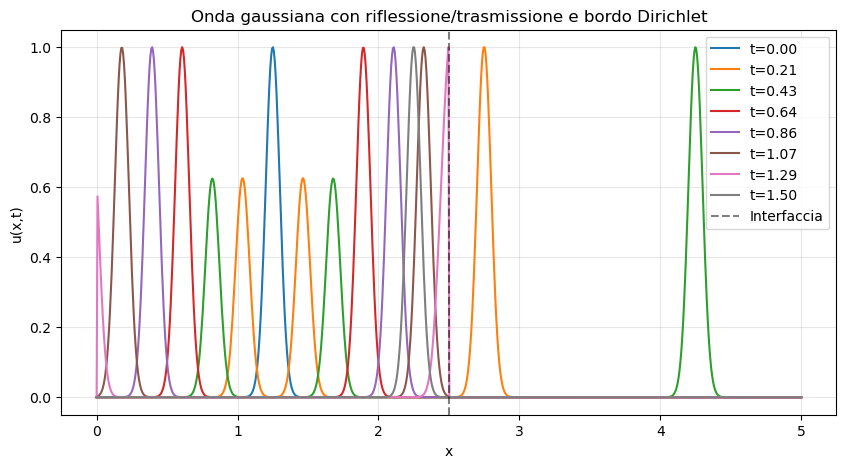

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri dominio
L = 5
nx = 800
x = np.linspace(0, L, nx)

# Parametri fisici
c1 = 1.0   # velocità nel primo mezzo
c2 = 4.0   # velocità nel secondo mezzo
x0 = L/4   # centro gaussiana iniziale
sigma = 0.05

# Coefficienti corretti
R = (c2 - c1) / (c1 + c2)   # riflessione all'interfaccia
T = (2 * c2) / (c1 + c2)    # trasmissione all'interfaccia

# Gaussiana
def gaussian(x, x0, sigma):
    return np.exp(-0.5 * ((x - x0) / sigma)**2)

def u_piecewise(x, t):
    u = np.zeros_like(x)
    for i, xi in enumerate(x):
        if xi < L/2:
            xi_inc = xi - c1*t
            xi_ref = (2*(L/2) - xi) - c1*t
            xi_left = xi + c1*t
            xi_left_ref = -xi_left
            u[i] = (
                gaussian(xi_inc, x0, sigma)
                + R * gaussian(xi_ref, x0, sigma)
                + gaussian(xi_left, x0, sigma)
                - gaussian(xi_left_ref, x0, sigma)
            )
        else:
            xi_tra = xi - c2*t - (c2 - c1)*t
            u[i] = T * gaussian(xi_tra, x0, sigma)

    u[0] = 0.0
    u[-1] = 0.0

    # Normalizzazione massima
    u /= np.max(np.abs(u))  
    return u

# Plot
plt.figure(figsize=(10,5))
for t in np.linspace(0, 1.5, 8):
    plt.plot(x, u_piecewise(x, t), label=f"t={t:.2f}")
plt.axvline(L/2, color="k", linestyle="--", alpha=0.5, label="Interfaccia")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Onda gaussiana con riflessione/trasmissione e bordo Dirichlet")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from ufl import MixedElement

# ----------------------- Utilities -----------------------

def gaussian_packet(x, x0, sigma, k0=0.0):
    """Complex Gaussian wave packet ψ(x) ∝ exp(-(x-x0)^2/(4σ^2)) * exp(i k0 (x-x0)).
    Returns (u, v) real/imag arrays and the normalization factor is applied to ensure ∫|ψ|^2=1 over domain.
    """
    # un-normalized envelope
    env = np.exp(- (x - x0)**2 / (4.0 * sigma**2))
    phase = k0 * (x - x0)
    u = env * np.cos(phase)
    v = env * np.sin(phase)
    # compute norm ∫|ψ|^2 dx ≈ sum |ψ|^2 Δx (use trapezoid later in FEM). We'll return raw; normalization will be done in FEM using mass matrix.
    return u, v

In [ ]:
# ----------------------- Core solver -----------------------

def tdse_1d(
    L=20.0,
    nx=2000,
    T=2.0,
    dt=0.002,
    hbar=1.0,
    m=1.0,
    V_func=None,   # callable V(x) or None for zero potential
    x0=5.0,
    sigma0=0.5,
    k0=0.0,
    bc_type="Dirichlet",  # or "Neumann" (natural)
    n_plots=6,
    plot_density=True,
):
    """Solve TDSE in 1D with Crank–Nicolson splitting real/imag.

    Returns time series of (t, sigma, mass) and final fields.
    """
    # Mesh and function spaces
    domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0.0, L])
    V = fem.functionspace(domain, ("Lagrange", 1))
    W = fem.FunctionSpace(domain, MixedElement([V.ufl_element(), V.ufl_element()]))

    # Trial/Test
    U_trial = ufl.TrialFunction(W)   # (u^{n+1}, v^{n+1})
    Phi     = ufl.TestFunction(W)    # (φ_u, φ_v)
    u_trial, v_trial = ufl.split(U_trial)
    phi_u, phi_v     = ufl.split(Phi)

    # Functions (past/present)
    U_n = fem.Function(W)
    u_n, v_n = U_n.split()

    # Coordinates and initial condition
    x = V.tabulate_dof_coordinates()[:, 0]
    u0_vals, v0_vals = gaussian_packet(x, x0=x0, sigma=sigma0, k0=k0)

    # Project initial u,v into V
    u_init = fem.Function(V)
    v_init = fem.Function(V)
    u_init.x.array[:] = u0_vals
    v_init.x.array[:] = v0_vals

    # Interpolate into mixed function
    with U_n.vector.localForm() as loc:
        pass  # Touch vector to ensure allocation
    U_n.sub(0).interpolate(lambda X: np.exp(- (X[0]-x0)**2 / (4.0*sigma0**2)) * np.cos(k0*(X[0]-x0)))
    U_n.sub(1).interpolate(lambda X: np.exp(- (X[0]-x0)**2 / (4.0*sigma0**2)) * np.sin(k0*(X[0]-x0)))

    # Potential V(x)
    if V_func is None:
        V_fun = fem.Function(V)
        V_fun.x.array[:] = 0.0
    else:
        V_fun = fem.Function(V)
        V_fun.interpolate(lambda X: V_func(X[0]))

    # Parameters and operators
    dx = ufl.dx
    du = ufl.grad(u_trial)
    dv = ufl.grad(v_trial)
    phi_u_grad = ufl.grad(phi_u)
    phi_v_grad = ufl.grad(phi_v)

    # Operator A = - (ħ^2 / 2m) ∂xx + V
    alpha = (hbar**2) / (2.0*m)
    cfac = dt / (2.0*hbar)

    # Left-hand side (CN implicit part)
    a11 = ufl.inner(u_trial, phi_u) * dx                          # u^{n+1} * φ_u
    a12 = - cfac * ( alpha*ufl.inner(du, phi_u_grad) * dx + ufl.inner(V_fun*u_trial, phi_u) * dx )  # - (dt/2ħ) A v^{n+1} but with u_trial? (we need cross with v)
    a21 =  cfac * ( alpha*ufl.inner(ufl.grad(u_trial), phi_v_grad) * dx + ufl.inner(V_fun*u_trial, phi_v) * dx )  # + (dt/2ħ) A u^{n+1}
    a22 = ufl.inner(v_trial, phi_v) * dx

    # Wait: we must couple u_trial with phi_u and v_trial with phi_u for cross terms properly.
    # Re-define carefully using blocks:
    u = u_trial; v = v_trial

    a = (
        ufl.inner(u, phi_u) * dx
        + ufl.inner(v, phi_v) * dx
        # Cross-coupling from CN implicit terms:
        - cfac * ( alpha*ufl.inner(ufl.grad(v), phi_u_grad) * dx + ufl.inner(V_fun*v, phi_u) * dx )
        + cfac * ( alpha*ufl.inner(ufl.grad(u), phi_v_grad) * dx + ufl.inner(V_fun*u, phi_v) * dx )
    )

    # Right-hand side (explicit part with U_n)
    u_n_f, v_n_f = ufl.split(U_n)
    L_form = (
        ufl.inner(u_n_f, phi_u) * dx
        + ufl.inner(v_n_f, phi_v) * dx
        + cfac * ( alpha*ufl.inner(ufl.grad(v_n_f), phi_u_grad) * dx + ufl.inner(V_fun*v_n_f, phi_u) * dx )
        - cfac * ( alpha*ufl.inner(ufl.grad(u_n_f), phi_v_grad) * dx + ufl.inner(V_fun*u_n_f, phi_v) * dx )
    )

    # Boundary conditions
    bcs = []
    if bc_type == "Dirichlet":
        zero = fem.Function(V); zero.x.array[:] = 0.0
        # both ends
        facets = mesh.locate_entities_boundary(domain, 0, lambda X: np.isclose(X[0], 0.0) | np.isclose(X[0], L))
        dofs = fem.locate_dofs_topological((W.sub(0), V), 0, facets)
        bcs += [fem.dirichletbc(zero, dofs, W.sub(0))]
        dofs = fem.locate_dofs_topological((W.sub(1), V), 0, facets)
        bcs += [fem.dirichletbc(zero, dofs, W.sub(1))]

    # Assemble matrix once (time-independent V)
    A = fem_petsc.assemble_matrix(fem.form(a), bcs=bcs)
    A.assemble()

    # Prepare solver (symmetric indefinite-like but real). Use LU for robustness.
    ksp = PETSc.KSP().create(domain.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    ksp.getPC().setType("lu")

    # Assemble vector
    L_vec = fem_petsc.create_vector(fem.form(L_form))

    # Helpers for diagnostics
    def mass_form(u_f, v_f):
        return (u_f*u_f + v_f*v_f) * dx
    def exp_x_form(u_f, v_f, power=1):
        xcoord = ufl.SpatialCoordinate(domain)[0]
        if power == 1:
            return (xcoord * (u_f*u_f + v_f*v_f)) * dx
        else:
            return (xcoord**2 * (u_f*u_f + v_f*v_f)) * dx

    # Normalize initial state to 1 (mass = ∫|ψ|^2)
    mass0 = fem.assemble_scalar(fem.form(mass_form(u_n_f, v_n_f)))
    mass0 = domain.comm.allreduce(mass0, op=MPI.SUM)
    scale = 1.0/np.sqrt(mass0)
    U_n.sub(0).x.array[:] *= scale
    U_n.sub(1).x.array[:] *= scale

    # Time loop
    nt = int(np.round(T/dt)) + 1
    t_vals = np.linspace(0., T, nt)
    t_plots = np.linspace(0., T, n_plots)

    sigmas = []
    masses = []

    # Analytical σ(t) for free particle (if V=0)
    def sigma_free(t):
        return sigma0 * np.sqrt(1.0 + (hbar * t / (2.0 * m * sigma0**2))**2)

    # Plot setup
    if plot_density:
        plt.figure(figsize=(10,6))

    for t in t_vals:
        # Diagnostics and plotting at selected times
        if plot_density and np.any(np.isclose(t, t_plots, atol=dt/2)):
            u_view, v_view = U_n.split()
            rho = u_view.x.array**2 + v_view.x.array**2
            plt.plot(x, rho, label=f"t={t:.3f}")

        # Compute ⟨x⟩, ⟨x^2⟩, σ
        u_f, v_f = ufl.split(U_n)
        mass = fem.assemble_scalar(fem.form(mass_form(u_f, v_f)))
        mass = domain.comm.allreduce(mass, op=MPI.SUM)
        x1 = fem.assemble_scalar(fem.form(exp_x_form(u_f, v_f, power=1)))
        x1 = domain.comm.allreduce(x1, op=MPI.SUM) / mass
        x2 = fem.assemble_scalar(fem.form(exp_x_form(u_f, v_f, power=2)))
        x2 = domain.comm.allreduce(x2, op=MPI.SUM) / mass
        sigma = np.sqrt(max(0.0, x2 - x1**2))
        sigmas.append((t, sigma))
        masses.append((t, mass))

        if np.isclose(t, T):
            break  # do not advance at final time

        # Build RHS
        L_vec.zeroEntries()
        fem_petsc.assemble_vector(L_vec, fem.form(L_form))
        fem_petsc.apply_lifting(L_vec, [fem.form(a)], bcs=[bcs])
        L_vec.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem_petsc.set_bc(L_vec, bcs)

        # Solve A U^{n+1} = b
        U_np1 = fem.Function(W)
        ksp.solve(L_vec, U_np1.vector)
        U_np1.x.scatter_forward()

        # Update
        U_n.x.array[:] = U_np1.x.array

    if plot_density:
        plt.xlabel("x")
        plt.ylabel(r"$|\psi(x,t)|^2$")
        plt.title("TDSE 1D — probability density (Crank–Nicolson)")
        plt.legend(); plt.grid(True); plt.show()

    # Plot sigma(t) and free-theory if V=0
    ts = np.array([t for t,_ in sigmas])
    svals = np.array([s for _,s in sigmas])
    plt.figure(figsize=(8,5))
    plt.plot(ts, svals, label=r"$\sigma(t)$ (FEM)")
    if V_func is None:
        plt.plot(ts, [sigma_free(tt) for tt in ts], linestyle='--', label=r"free theory")
    plt.xlabel("t"); plt.ylabel(r"$\sigma(t)$"); plt.title("Wave packet width vs time"); plt.legend(); plt.grid(True); plt.show()

    return {
        "times": ts,
        "sigma": svals,
        "mass": np.array([m for _,m in masses]),
        "final_state": U_n
    }

In [ ]:
# ----------------------- Example run (Free particle) -----------------------
if __name__ == "__main__":
    L = 40.0
    nx = 3000
    T  = 4.0
    dt = 0.002
    hbar = 1.0
    m = 1.0
    x0 = 10.0
    sigma0 = 0.7
    k0 = 5.0   # give some momentum so the packet drifts; set 0.0 to see symmetric spreading

    result = tdse_1d(L=L, nx=nx, T=T, dt=dt, hbar=hbar, m=m,
                     V_func=None, x0=x0, sigma0=sigma0, k0=k0,
                     bc_type="Dirichlet", n_plots=6, plot_density=True)

    # Print basic diagnostics
    print(f"Mass conservation: m(0)={result['mass'][0]:.6f}, m(T)={result['mass'][-1]:.6f}")
    print(f"Initial sigma={result['sigma'][0]:.4f}, Final sigma={result['sigma'][-1]:.4f}")

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------